# HOMEWORK 06

## Exercise 1

Poisson regression is a Generalized Linear Model, used to model count data. It takes the form:

$$E(\mu | x) = exp(w_1 \cdot x_1 + \cdots + w_k \cdot x_k + b)$$

where the observed counts $y$ are drawn from a Poisson distribution on the expected counts:

$$y_i \sim Poisson(\mu_i)$$

In [1]:
import pyro
import torch
import copy
import math
import statsmodels.api as sm
import tensorflow as tf
from sklearn import metrics
from sklearn import datasets
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints
sns.set_style("darkgrid")
figsize=(10,4)
pyro.set_rng_seed(0)

In [2]:
def split_function(data, input_data, output_data, split_percent):
    
    """
    This function split the dataset in train set and test set
    
    Parameters
    ----------
    data           : dataframe
        it is the dataset on which to perform the splitis the dataset 
    input_data     : list
        it is a list of columns name of the dataset, 
        used to define the independent feature(s)
    output_data    : list
        it is a list of column used to define 
        the dependent feature
    split_percent  : float
        it is the percent of data used to the train set, so 1 - split_percent
        is the percent of rows used to the test set
        
    Returns
    -------
    X      : array
        independent variable
    Y      : array
        dependent variable
    X_train: array
        it is the train input
    Y_train: array
        it is the train output
    X_test : array
        it is the test input
    Y_test : array
        it is the test output
    """
    
    # divide dataset in input data and output data
    X = data.filter(items = input_data).values
    Y = data.filter(items = output_data).values[:, 0]

    n_rows = int(X.shape[0] * split_percent)

    # train set
    X_train = X[ : n_rows]
    Y_train = Y[ : n_rows]

    # test set
    X_test = X[n_rows : ]
    Y_test = Y[n_rows : ]
    
    return torch.Tensor(X), torch.Tensor(Y), torch.Tensor(X_train), torch.Tensor(Y_train), torch.Tensor(X_test), torch.Tensor(Y_test)

1. Download and import Load the smoking dataset from: https://data.princeton.edu/wws509/datasets/#smoking. Then perform a train-test split on the data.

In [3]:
# load dataset
columns_field = ["age", "smoke", "pop", "dead"]
path = '/home/pietro/Documents/Statistical_machine_learning/git_professor/notebooks/data/smoking.raw'
dataset = pd.read_csv(path, sep = '\t', names = columns_field).dropna()
dataset

,age,smoke,pop,dead
0,1,1,656,18
1,2,1,359,22
2,3,1,249,19
3,4,1,632,55
4,5,1,1067,117
5,6,1,897,170
6,7,1,668,179
7,8,1,361,120
8,9,1,274,120
9,1,2,145,2


In [4]:
# deep copy
data_1 = copy.deepcopy(dataset) # work on a deep copied version of the original dataset

# split dataset
input_data = ['age', 'smoke', 'pop']
output_data = ['dead']
percent = 0.8 # 80% to train and 20% to test

X, Y, X_train, Y_train, X_test, Y_test = split_function(data_1, input_data, output_data, percent)

2. Fit a Poisson bayesian regression model using the number of deaths as the response variable and the other columns as the explanatory variables.

In [11]:
# modelling rain in terms of the predictors
def model(X, Y):

    n_observations, n_predictors = X.shape
    
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b = pyro.sample("b", dist.LogNormal(torch.zeros(1), torch.ones(1)))

    mu = torch.exp((w*X).sum(dim=1) + b)

    # condition on the observations
    with pyro.plate("death", len(Y)):
        pyro.sample("obs", dist.Poisson(mu), obs = Y)
        
def guide(X, Y=None):
    
    n_observations, n_predictors = X.shape

    w_loc = pyro.param("w_loc", torch.rand(n_predictors), constraint=constraints.positive)
    w_scale = pyro.param("w_scale", torch.rand(n_predictors), constraint=constraints.positive)

    w = pyro.sample("w", dist.Gamma(w_loc, w_scale))

    b_loc = pyro.param("b_loc", torch.rand(1))
    b_scale = pyro.param("b_scale", torch.rand(1), constraint=constraints.positive)

    b = pyro.sample("b", dist.LogNormal(b_loc, b_scale))
    
    
svi = SVI(model, guide, optim = optim.ClippedAdam({'lr' : 0.01}), loss = Trace_ELBO()) 

for step in range(2000):
    loss = svi.step(X_train, Y_train)/len(X_train)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 6.765145009490463e+19
Step 100 : loss = 404.10631167037144
Step 200 : loss = 2.931264524233943e+20
Step 300 : loss = 547.8021559246948
Step 400 : loss = 234.98099682160787
Step 500 : loss = 9.73168769729655e+19
Step 600 : loss = 338.6285629570484
Step 700 : loss = 598.9491776142802
Step 800 : loss = 1663939117056.4314
Step 900 : loss = 3786965927030199.0
Step 1000 : loss = 5868.801077578749
Step 1100 : loss = 895758.4968279728
Step 1200 : loss = 35791.82661042469
Step 1300 : loss = 451.7622241633279
Step 1400 : loss = 85.2692508144038
Step 1500 : loss = 146.9536946075303
Step 1600 : loss = 1824826476836.8484
Step 1700 : loss = 4783.548344561032
Step 1800 : loss = 34337673.484897
Step 1900 : loss = 97.5635133428233


In [163]:
X_test_pandas = pd.DataFrame(X_test.numpy(), columns = data_1.columns[0:3])
data_1.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35],
           dtype='int64')

In [155]:
poisson_training_results = sm.GLM(Y_train.numpy(), X_train.numpy(), family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   28
Model:                            GLM   Df Residuals:                       25
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -821.80
Date:                Sun, 17 May 2020   Deviance:                       1463.5
Time:                        14:46:12   Pearson chi2:                 1.82e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4513      0.006     80.479      0.0

In [156]:
poisson_predictions = poisson_training_results.get_prediction(X_test.numpy())#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

         mean    mean_se  mean_ci_lower  mean_ci_upper
0  115.676008   5.954902     104.574108     127.956519
1  151.010789   7.397722     137.185840     166.228952
2  466.066548  16.780481     434.311040     500.143923
3  937.967122  27.232929     886.081844     992.890586
4  767.151964  24.739459     720.164109     817.205590
5  671.975446  24.528063     625.580687     721.810966
6  735.187003  28.383384     681.609226     792.976252
7  989.929035  37.871565     918.416704    1067.009659


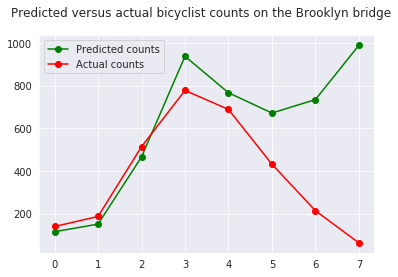

In [162]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = Y_test.numpy()

fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')

predicted, = plt.plot(range(0, len(X_test)), predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(range(0, len(X_test)), actual_counts, 'ro-', label='Actual counts')

plt.legend(handles=[predicted, actual])
plt.show()

In [9]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

# w_i and b posterior mean
inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]

for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

Inferred params: ['w_loc', 'w_scale', 'b_loc', 'b_scale']

w_0 = 0.37164214
w_1 = 0.42360276
w_2 = 0.21458410
b = 0.18369810


3. Evaluate the regression fit on test data using MAE and MSE error metrics.

In [10]:
# compute predictions using the inferred paramters
Y_pred = (inferred_w * X_test).sum(1) + inferred_b

print("MAE =", torch.nn.L1Loss()(Y_test, Y_pred).item())
print("MSE =", torch.nn.MSELoss()(Y_test, Y_pred).item())

MAE = 159.01727294921875
MSE = 34037.4921875


## Exercise 2

The Iris dataset contains petal and sepal length and width for three different types of Iris flowers: Setosa, Versicolour, and Virginica.

1. Import the Iris dataset from sklearn and perform a train-test split on the data.

In [114]:
iris = datasets.load_iris() # dataset

iris_fields = ["sepal_length", "sepal_width", "petal_length", "petal_width"] # features
iris_dataset = pd.DataFrame(iris["data"], columns = iris_fields) # convert the array into a dataframe
iris_dataset["species"] = iris["target"] # add the output at the dataset

# deep copy
data_2 = copy.deepcopy(iris_dataset) # work on a deep copied version of the original dataset

labels = torch.tensor(iris_dataset["species"].values, dtype=torch.double)

# dataset normalization
data_2 = (data_2 - data_2.min())/(data_2.max() - data_2.min())

input_data = iris_fields
output_data = ["species"]
percent = 0.8 # 80% to train and 20% to test

X, Y, X_train, Y_train, X_test, Y_test = split_function(data_2, input_data, output_data, percent)

2. Fit a multinomial bayesian logistic regression model on the four predictors petal length/width and sepal length/width.

Step 0 : loss = 4.929528011878332
Step 1000 : loss = 4.708877304196358
Step 2000 : loss = 4.762202933430672
Step 3000 : loss = 4.793398720026016
Step 4000 : loss = 4.415220125516256
Step 5000 : loss = 4.237621950606505
Step 6000 : loss = 4.536731730401516
Step 7000 : loss = 4.1832146088282265
Step 8000 : loss = 4.156943706671397
Step 9000 : loss = 4.214182335138321


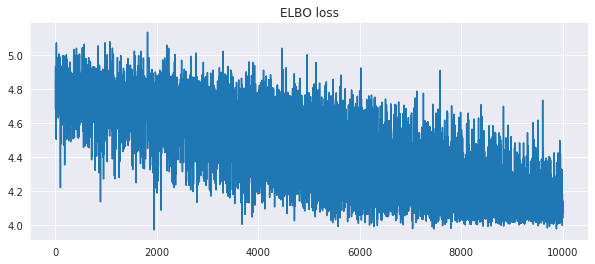

In [115]:
pyro.clear_param_store()

def log_reg_model(x, y):
    n_observations, n_predictors = x.shape
    
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b = pyro.sample("b", dist.Normal(0.,1.))
    
    # non-linearity
    yhat = torch.sigmoid((w*x).sum(dim=1) + b)
    
    with pyro.plate("data", n_observations):
        # sampling 0-1 labels from Categorical distribution
        y = pyro.sample("y", dist.Categorical(yhat), obs=y)
        
def log_reg_guide(x, y=None):
    
    n_observations, n_predictors = x.shape
    
    w_loc = pyro.param("w_loc", torch.rand(n_predictors))
    w_scale = pyro.param("w_scale", torch.rand(n_predictors), constraint=constraints.positive)
    w = pyro.sample("w", dist.Normal(w_loc, w_scale))
    
    b_loc = pyro.param("b_loc", torch.rand(1))
    b_scale = pyro.param("b_scale", torch.rand(1), constraint=constraints.positive)
    b = pyro.sample("b", dist.Normal(b_loc, b_scale))

    
log_reg_svi = SVI(model=log_reg_model, guide=log_reg_guide, 
              optim=optim.ClippedAdam({'lr' : 0.0002}), 
              loss=Trace_ELBO()) 

losses = []
for step in range(10000):
    loss = log_reg_svi.step(X_train, Y_train)/len(X_train)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")
        
fig, ax = plt.subplots(figsize=figsize)
ax.plot(losses)
ax.set_title("ELBO loss");

3. Evaluate your bayesian classifier on test data: compute the overall test accuracy and class-wise accuracy for the three different flower categories.

In [118]:
w = pyro.get_param_store()["w_loc"]
b = pyro.get_param_store()["b_loc"]

def predict_class(x, threshold):
    out = torch.sigmoid((w * x).sum(dim=1) + b)
    return out > threshold

In [119]:
threshold = 0.5
correct_predictions = (predict_class(X_test, threshold) == Y_test).sum().item()
print(f"test accuracy = {correct_predictions/len(X_test)*100:.2f}%")

test accuracy = 0.00%


In [125]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


#Create a pandas DataFrame for the counts data set.
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

#Add a few derived regression variables.
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

#Create the training and testing data sets.
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

#Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and
# it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

#Set up the X and y matrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']

#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

FileNotFoundError: [Errno 2] File nyc_bb_bicyclist_counts.csv does not exist: 'nyc_bb_bicyclist_counts.csv'